# WikiRecentPhase1 - 


## Continious processing with Streams.

[WikiRecentPhase0](imgAna_0.jupyter-py36.ipynb) illustrated accessing continious streams events from a notebook in Python as a way to explore the nature of the data and to understand how to develop it into useful insights. In that exploration data is collected, averages are calculated only as long as the notebook open and specific cells are running. That model makes it challenging to make business use of insights derived from the stream.


In this notebook we will transition the work we did with the data in step 0 to a continuously running Streams job, develop the insights further and show how the Notebook can be used to access the outputs of the job for user visualization and action.

## Overview 
**About the sample** 

The appliction recieves Wikipedia updates as events via SSE. An event
has a 'bots' field indicating that it was generated by a robot. Many robots exist Wikipedia to perform
mandane checking tasks: checking, copyright infringment,inappropriate content...
This application will focus on messages generated by humans filtering out those from 'bots'. 
The event has a number of superflous fields that are removed before it is presented to 'view'. 

A 'view'enables a developer to observe data that is flowing through the live stream, data presented to the 
view is available for display over the web. Due to the realtime nature of Streams the view may and the 
limitations of web communcations a view will drop observations as resources (CPU, memory, bandwidy) become limited. 
This has not been an issue with this suite of notebooks.

The application is composed and submitted from the notebook, it runs on a server continiously until it is stopped. 
This notebook accesses and renders view data in order to see how the Streams is processing the events 
recieved from Wikipedia. 





### Documentation

- [Streams Python development guide](https://ibmstreams.github.io/streamsx.documentation/docs/latest/python/)
- [Streams Python API](https://streamsxtopology.readthedocs.io/)
- [Topology](https://streamsxtopology.readthedocs.io/en/latest/index.html) Streams Topology documentation
- [Widgets](https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20Basics.html) Notebook Widgets documentation.





## Submit the appplication that has a filter. 

- rough cut look at the data
- plot the 'type' data
- look at the filtered data

##  Collect in buffer / Aggregate
- Last 1000 in local buffer & aggregate
- Render
- Push code to server.


<a name="setup"></a>
# Setup
### Add credentials for the IBM Streams service

#### ICPD setup

With the cell below selected, click the "Connect to instance" button in the toolbar to insert the credentials for the service.

<a target="blank" href="https://developer.ibm.com/streamsdev/wp-content/uploads/sites/15/2019/02/connect_icp4d.gif">See an example</a>.

#### Cloud setup

To use Streams instance running in the cloud setup a [credential.py](setup_credential.ipynb)

## Imports 

In [5]:
# Install components
!pip install sseclient
!pip install --user --upgrade streamsx

Requirement already up-to-date: streamsx in /Users/siegenth/.local/lib/python3.6/site-packages (1.13.5)


Initial imports are in support of accessing Streams with Wikipedia data, 
subsequent are in support of rendering the results as they flow back from 
Streams. 

In [6]:
## Operational 
from streamsx.topology.topology import *
import streamsx.rest as rest
import streamsx.topology.context

from sseclient import SSEClient as EventSource

import urllib3

## Renderng
import pandas as pd
from IPython.core.debugger import set_trace
from IPython.display import display, clear_output

from statistics import mean
from collections import deque
from collections import Counter

import json

import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import Button, HBox, VBox, Layout
%matplotlib inline

from streamsx.topology import context

print("streamsx package version: " + streamsx.topology.context.__version__)

streamsx package version: 1.13.5


## Helper functions used in interfacing  to Streams  
Make interacting with the Streams data friendlier.

In [7]:
def catchInterrupt(func):
    """decorator : when interupt occurs the display is lost if you don't catch it
       TODO * <view>.stop_data_fetch()  # stop
       
    ."""
    def catch_interrupt(*args, **kwargs):
        try: 
            func(*args, **kwargs)
        except (KeyboardInterrupt): pass
    return catch_interrupt


def display_view_stop(eventView, period=2):
    """Wrapper for streamsx.rest_primitives.View.display() to have button. """
    button =  widgets.Button(description="Stop Updating")
    display(button)
    eventView.display(period=period) 
    def on_button_clicked(b):
        eventView.stop_data_fetch()
        b.description = "Stopped"
    button.on_click(on_button_clicked)

def view_events(views):
    """
    Build interface to display a list of views and 
    display view when selected from list.
     
    """
    view_names = [view.name for view in views]
    nameView = dict(zip(view_names, views))    
    select = widgets.RadioButtons(
        options = view_names,
        value = None,
        description = 'Select view to display',
        disabled = False
    )
    def on_change(b):
        if (b['name'] == 'label'):
            clear_output(wait=True)
            [view.stop_data_fetch() for view in views ]
            display(select)
            display_view_stop(nameView[b['new']], period=2)
    select.observe(on_change)
    display(select)

def find_job(instance, job_name=None):
    """locate job within instance"""
    for job in instance.get_jobs():    
        if job.applicationName.split("::")[-1] == job_name:
            return job
    else:
        return None
    
def get_view(instance, job_name=None, view_name="view"):
    job = find_job(instance, job_name)
    return job.get_views(view_name)
    

def display_views(instance, job_name):
    "Locate/promote and display all views of a job"
    job = find_job(instance, job_name=job_name)
    if job is None:
        print("Failed to locate job")
    else:
        views = job.get_views()
        view_events(views)
        
def list_jobs(_instance=None, cancel=False):
    """
    Interactive selection of jobs to cancel.
    
    Prompts with SelectMultiple widget, if thier are no jobs, your presente with a blank list.
    
    """
    active_jobs = { "{}:{}".format(job.name, job.health):job for job in _instance.get_jobs()}

    selectMultiple_jobs = widgets.SelectMultiple(
        options=active_jobs.keys(),
        value=[],
        rows=len(active_jobs),
        description = "Cancel jobs(s)" if cancel else "Active job(s):",
        layout=Layout(width='60%')
    )
    cancel_jobs = widgets.ToggleButton(
        value=False,
        description='Cancel',
        disabled=False,
        button_style='warning', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Delete selected jobs',
        icon="stop"
    )
    def on_value_change(change):
        for job in selectMultiple_jobs.value:
            print("canceling job:", job, active_jobs[job].cancel())
        cancel_jobs.disabled = True
        selectMultiple_jobs.disabled = True

    cancel_jobs.observe(on_value_change, names='value')
    if cancel:
        return HBox([selectMultiple_jobs, cancel_jobs])
    else:
        return HBox([selectMultiple_jobs])
 

## Connect to the server :  ICP4D or Cloud instance -


In [8]:
def get_instance():
    """Setup to access your Streams instance.

    ..note::The notebook is work within Cloud and ICP4D. 
            Refer to the 'Setup' cells above.              
    Returns:
        instance : Access to Streams instance, used for submitting and rendering views.
    """
    try:
        from icpd_core import icpd_util
        import urllib3
        global cfg
        cfg[context.ConfigParams.SSL_VERIFY] = False
        instance = rest.Instance.of_service(cfg)
        print("Within ICP4D")
        urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
    except ImportError:
        cfg = None
        print("Outside ICP4D")
        import credential  
        sc = rest.StreamingAnalyticsConnection(service_name='Streaming3Turbine', 
                                               vcap_services=credential.vcap_conf)
        instance = sc.get_instances()[0]
    return instance,cfg

instance,cfg = get_instance()

Outside ICP4D


### List jobs to cancel....
This page will submit a job named 'WikiPhase1'. If it's running you'll want to cancel it before submitting a new version. 

In [9]:
list_jobs(instance, cancel=True)

# Composing the Streams application
- get data from wiki usng SSE
- filter data, seperate out the humans and RObots
- setup views : allEvents, allHumans, paredHumans, paredAll

## Receive messages updates from Wikipedia
As updates are made to Wikipidia pages the changs are sent over and SSE feed. The get_events() function recieves the events and acting as a [source](https://streamsxtopology.readthedocs.io/en/latest/streamsx.topology.topology.html#streamsx.topology.topology.Topology.source) pushes them onto the Streams streams.

This is functional the same code as the 'imgAna0' notebook.

In [10]:
def get_events():
    """fetch recent changes from wikievents site using SSE"""
    for change in EventSource('https://stream.wikimedia.org/v2/stream/recentchange'):
        if len(change.data):
            try:
                obj = json.loads(change.data)
            except json.JSONDecodeError as err:
                print("JSON l1 error:", err, "Invalid JSON:", change.data)
            except json.decoder.JSONDecodeError as err:
                print("JSON l2 error:", err, "Invalid JSON:", change.data)
            else:
                yield(obj)


## Filter messages
The [filter](https://streamsxtopology.readthedocs.io/en/latest/streamsx.topology.topology.html#streamsx.topology.topology.Stream.filter) is used to break out messages not generated by robots.

## View into the live stream
The [view](https://streamsxtopology.readthedocs.io/en/latest/streamsx.topology.topology.html#streamsx.topology.topology.Stream.view) enables access to live stream at runtime. We spread them liberaly throughout the application to observe how the processing is procedeing

<a id='composeBuildSubmit'></a>
## Compose, build and submit the Streams application.¶

The following Code cell composes the Streams application depicted here:

![graph of application](images/stillPhase1.jpg)

From a single event source (wikiEvents)' we are creating a topology that delivers two streams of derived information.
To make each step in this process accessible to examination we are declaring a view at each stage to look at the raw data and also to attach graphical visualizations. 

A Steams flow is composed by linking operator outputs to inputs.

Two streams are being composed and three views are exposed

1) All source events are sent to 'allEvents' view where they are exposed for viewing.

2) All the source events sent to 'paredAll', where they are pared down to 6 fields and exposed for viewing. 
- the Wikipeida events are output from the 'source' method named 'wikiEvents on 'wiki_events' 
- the input to the 'map' method named 'paredAll'is wiki_events where fields  ('timestamp',type','wiki','bot','user','title') are extracted and output to 'pared_all'. 
- the input to 'view' method is 'named allEvents is 'pared_all' where the are exposed for viewing. 

3) All the source events are sent to 'humansOnly' that drops 'bot' fields of False, they are then are pared down to 5 fields and exposed for viewing.
- the Wikipeida events are output from the 'source' method named 'wikiEvents on 'wiki_events' 
- the input to the 'filter' method named 'humanFilter' only events in whih the 'bot' field set to False are output on all_human. 
- the input to the 'map' method named 'paredHuman' is all_human where fields  ('timestamp',type','wiki','user','title') are extracted and output to 'pared_human'. 
- the input to 'view' method is named 'paredHuman' is 'pared_human' where the are exposed for viewing. 

In [11]:
def WikiPhase1(jobName=None):
    """
    Compose topology 

    """
    topo = Topology(name=jobName)
    topo.add_pip_package('sseclient')

    ## Receive wiki data 
    wiki_events = topo.source(get_events, name="wikiEvents")
    wiki_events.view(buffer_time=1.0, sample_size=1, name="allEvents", description="All wiki events")
    
    ## drop fields 
    pared_all = wiki_events.map(lambda x : {'timestamp':x['timestamp'],'type':x['type'],'wiki':x['wiki'],'bot':x['bot'],'user':x['user'],'title':x['title']}, name="paredAll")
    pared_all.view(buffer_time=1.0, sample_size=200, name="paredAll", description="All events pared")
    
    ## Filter out bots 
    all_human = wiki_events.filter(lambda x: x['bot'] is False, name='humanFilter')

    ## drop fields
    pared_human = all_human.map(lambda x : {'timestamp':x['timestamp'],'type':x['type'],'wiki':x['wiki'],'user':x['user'],'title':x['title']}, name="paredHuman")
    pared_human.view(buffer_time=1.0, sample_size=200, name="paredHuman", description="Human events pared")
    
    return ({"topo":topo})

## Submit topology : build/submit (ICP4D or Cloud)

In [12]:
resp = WikiPhase1(jobName="WikiPhase1")
if cfg is not None:
    # Disable SSL certificate verification if necessary
    cfg[context.ConfigParams.SSL_VERIFY] = False
    submission_result = context.submit("DISTRIBUTED",resp['topo'], config=cfg)

if cfg is None:
    import credential
    cloud = {
        context.ConfigParams.VCAP_SERVICES: credential.vcap_conf,
        context.ConfigParams.SERVICE_NAME: "Streaming3Turbine",
        context.ContextTypes.STREAMING_ANALYTICS_SERVICE:"STREAMING_ANALYTIC",
        context.ConfigParams.FORCE_REMOTE_BUILD: True,
    }
    submission_result = context.submit("STREAMING_ANALYTICS_SERVICE",resp['topo'],config=cloud)

# The submission_result object contains information about the running application, or job
if submission_result.job:
    print("JobId: ", submission_result['id'] , "Name: ", submission_result['name'])

IntProgress(value=0, bar_style='info', description='Initializing', max=10, style=ProgressStyle(description_wid…

Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.ng.bluemix.net"
Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.ng.bluemix.net"
Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.ng.bluemix.net"
Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.ng.bluemix.net"
Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.n

JobId:  0 Name:  ipythoninput115634556a537e::WikiPhase1_0


<a id='viewingData'></a>
## Viewing data 

The running application has number of views to see what what data is moving through the stream. The following 
cell will fetch the views' queue and dipslay it's data when selected. 

|view name | description of data is the view |
|---------|-------------|
|allEvents  | all fields of all events  |
|paredAll | subset of fields for all events |
|paredHumans | subset of fields of all events where field 'bot is **False**|

Running the cell below will bring up the list of active views from which data can be seen. 

When done 'Stop Updating', continious Widget updates are browser resource expensive. 



In [13]:
# Render the views.....
display_views(instance, job_name="WikiPhase1")

RadioButtons(description='Select view to display', index=2, options=('allEvents', 'paredAll', 'paredHuman'), v…

Button(description='Stop Updating', style=ButtonStyle())

# Viewing live data:
- constructing the view object : https://streamsxtopology.readthedocs.io/en/latest/streamsx.topology.topology.html?highlight=view#streamsx.topology.topology.Stream.view
- methods on the view object : https://streamsxtopology.readthedocs.io/en/latest/streamsx.topology.topology.html?highlight=view#streamsx.topology.topology.View

## Graph frequency of 'type' events and 'bots'

The following is a example of using widgets to view the live data, accessing the 'paredAll' view data, we're able to
see the counts of edit types to bots/non-bot (human) 


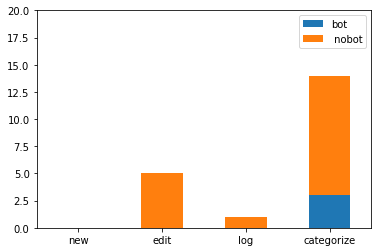

In [14]:
# tally the the bots/types
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets
%matplotlib inline
from collections import Counter

@catchInterrupt
def tally_bot(view, ele_window=20, count=20):
    """bots vs human updates 
    Args:
        view: Streams view that data will be fetched from
        ele_window : max number of elements in window
        count: number of times to fetch data, < 0 until interrupt 
    
    """

    nam_list = ['new', 'edit', 'log','categorize']
    cntbot = {key:0 for key in nam_list}
    cntnobot = {key:0 for key in nam_list}
    view.start_data_fetch()

    while count != 0:
        count -= 1
        listTuples= view.fetch_tuples(max_tuples=20, timeout=4)
        cntbot = Counter({key:0 for key in nam_list})
        cntnobot = Counter({key:0 for key in nam_list})
        for evt in listTuples:
            if evt['bot']:
                cntbot[evt['type']] += 1
            else:
                cntnobot[evt['type']] += 1
        bot_list = [cntbot[key] for key in nam_list]
        nobot_list = [cntnobot[key] for key in nam_list]
        
        df = pd.DataFrame({'bot': bot_list, ' nobot': nobot_list}, index=nam_list)
        df.plot.bar(rot=0, stacked=True)
        plt.ylim(0.0, ele_window)
        plt.show()
        clear_output(wait=True)

view = get_view(instance, job_name="WikiPhase1", view_name="paredAll")
tally_bot(view=view[0])



## Graph frequency of *bot*less 'type'  : Avg vs instant

Display the last set of counts and the average of the last 20 sets utlizing the 'paredHuman' view. 


In [15]:
# Aggregate colllections of rows - support

class chunking_average:
    def __init__(self, init_base, mean_elements=20):
        self.deques = {key:deque([0],maxlen=mean_elements) for key in init_base.keys()}

    def aggregate(self, chunk):
        for key in self.deques.keys():
            if self.deques[key] and chunk[key]: self.deques[key].append(chunk[key])
        return {key:mean(self.deques[key]) for key in self.deques.keys()}

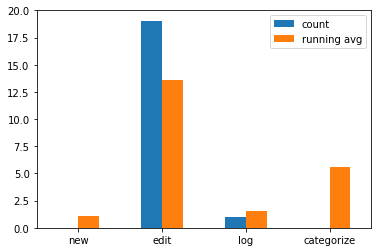

In [16]:
@catchInterrupt
def tally_types(view, ele_window=20, count=20):
    """bar chart instant count vs running count. 
    Args:
        view: Streams view that data will be fetched from
        ele_window : max number of elements in window
        count: number of times to fetch data, < 0 until interrupt 
    
    """

    global resp
    nam_list = ['new', 'edit', 'log','categorize']
    cnt = {key:0 for key in nam_list}
    run_avg = chunking_average(cnt)
    view.start_data_fetch()


    while count != 0:
        count -= 1
        listTuples= view.fetch_tuples(max_tuples=20, timeout=3)
        cnt = Counter({key:0 for key in nam_list})
        for evt in listTuples:cnt[evt['type']] += 1
        avg = run_avg.aggregate(cnt)
        evt_list = [cnt[key] for key in nam_list]
        avg_list = [avg[key] for key in nam_list]
        df = pd.DataFrame({'count': evt_list, 'running avg': avg_list}, index=nam_list)
        df.plot.bar(rot=0)
        plt.ylim(0.0, ele_window)
        plt.show()
        clear_output(wait=True)
view = get_view(instance, job_name="WikiPhase1", view_name="paredHuman")
tally_types(view=view[0])

# Cancel job when done. 

In [17]:
list_jobs(instance, cancel=True)

Exception in thread Thread-13:
Traceback (most recent call last):
  File "/Users/siegenth/anaconda3/envs/icp4d3_6/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/siegenth/anaconda3/envs/icp4d3_6/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/siegenth/.local/lib/python3.6/site-packages/streamsx/rest_primitives.py", line 459, in __call__
    _items = self._get_deduplicated_view_items() or []
  File "/Users/siegenth/.local/lib/python3.6/site-packages/streamsx/rest_primitives.py", line 478, in _get_deduplicated_view_items
    items = self.view.get_view_items()
  File "/Users/siegenth/.local/lib/python3.6/site-packages/streamsx/rest_primitives.py", line 760, in get_view_items
    in self.rest_client.make_request(self.viewItems)['viewItems']]
  File "/Users/siegenth/.local/lib/python3.6/site-packages/streamsx/rest_primitives.py", line 202, in make_request
    _handle_http_errors(res)
  File "

canceling job: ipythoninput115634556a537e::WikiPhase1_0:healthy True


Exception in thread Thread-14:
Traceback (most recent call last):
  File "/Users/siegenth/anaconda3/envs/icp4d3_6/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/siegenth/anaconda3/envs/icp4d3_6/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/siegenth/.local/lib/python3.6/site-packages/streamsx/rest_primitives.py", line 459, in __call__
    _items = self._get_deduplicated_view_items() or []
  File "/Users/siegenth/.local/lib/python3.6/site-packages/streamsx/rest_primitives.py", line 478, in _get_deduplicated_view_items
    items = self.view.get_view_items()
  File "/Users/siegenth/.local/lib/python3.6/site-packages/streamsx/rest_primitives.py", line 760, in get_view_items
    in self.rest_client.make_request(self.viewItems)['viewItems']]
  File "/Users/siegenth/.local/lib/python3.6/site-packages/streamsx/rest_primitives.py", line 202, in make_request
    _handle_http_errors(res)
  File "

# Notebook wrapup 

This notebook composed and deployed a Streams application that processes live Wikipedia events on a server. After 
filtering the events they're pared down and made avaiable via a view. Using standard notebook widgets
we rendered the view data. 

This application is running on server, once deployed it is not necessary to have notebook open and executing in order to process the data. Future notebooks will collect and average data over windows of events and time. 

